In [1]:
import os
import pandas as pd
import sklearn.metrics
import numpy as np
import plotnine as p9
import optuna
import scipy.stats as stats 
import itertools
import warnings
warnings.filterwarnings('ignore')

/opt/homebrew/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
TRIALS = 250
TOP_N = 1

In [3]:
def load_performance_metrics(dataset, gnn, llm, method, aggregation, display_information = False):
  
  study_name = f'{dataset}-{gnn}-{llm.replace("/", "-")}-{method}-{aggregation}'
  storage = f'sqlite:///../../pipelines/optuna_studies/{study_name}.db'
  study = optuna.load_study(study_name = study_name, storage = storage)
  
  study_df = study.trials_dataframe()

  study_df = study_df[study_df['value'] >= 0.0].sort_values(by = 'number', ascending = True)
  columns = ['number', 'value'] + [x for x in study_df.columns if x.startswith('params_')] + [x for x in study_df.columns if x.startswith('user_attrs_')]

  top_trials = study_df[columns].head(TRIALS).sort_values(by = ['value', 'user_attrs_validation_loss', 'user_attrs_training_loss'], ascending = [False, True, True]).head(TOP_N) # .head(3) for R8, BART-large due to exceptions
  
  performance = list()
  #for trial in [x for x in os.listdir(f'../../outputs/{dataset}-{gnn}-{llm}/{method}/{aggregation}') if os.path.isdir(f'../../outputs/{dataset}-{gnn}-{llm}/{method}/{aggregation}/{x}')]:
  for _, row in top_trials.iterrows():
    
    if display_information:
      print(row)
    trial = row['number']

    for random_state in [x for x in os.listdir(f'../../outputs/{dataset}-{gnn}-{llm}/{method}/{aggregation}/{trial}') if os.path.isdir(f'../../outputs/{dataset}-{gnn}-{llm}/{method}/{aggregation}/{trial}/{x}')]:
      df = pd.read_csv(f'../../outputs/{dataset}-{gnn}-{llm}/{method}/{aggregation}/{trial}/{random_state}/predictions.csv')
      for split in ['validation', 'test']:
        df_split = df[df['split'] == split]
        accuracy = sklearn.metrics.accuracy_score(df_split['real'], df_split['prediction'])
        f1_score = sklearn.metrics.f1_score(df_split['real'], df_split['prediction'], average = 'macro')
        precision = sklearn.metrics.precision_score(df_split['real'], df_split['prediction'], average = 'macro')
        recall = sklearn.metrics.recall_score(df_split['real'], df_split['prediction'], average = 'macro')
        performance.append((trial, random_state, split, accuracy, f1_score, precision, recall))
  return pd.DataFrame(performance, columns = ['trial', 'random_state', 'split', 'accuracy', 'f1_score', 'precision', 'recall'])

In [4]:
def remove_trials_with_exceptions(df):
  return df.groupby(['trial']).filter(lambda x : len(x) >= 10 * 2).reset_index(drop = True)

In [5]:
def get_best_results(dataset, gnn, llm, method, aggregation, target_metric):
  df = load_performance_metrics(dataset = dataset, gnn = gnn, llm = llm, method = method, aggregation = aggregation, display_information = True)
  df = remove_trials_with_exceptions(df)
  df_aggregated = df.groupby(['trial', 'split']).agg({
    'accuracy' : ['mean', 'std'],
    'f1_score' : ['mean', 'std'],
    'precision' : ['mean', 'std'],
    'recall' : ['mean', 'std'],
  }).reset_index()
  df_aggregated.columns = df_aggregated.columns.map('_'.join).str.strip('_')
  
  best_trial_number = df_aggregated.sort_values(by = ['split', f'{target_metric}_mean', f'{target_metric}_std'], ascending = [True, False, True]).reset_index(drop = True).iloc[0]['trial']

  best_trial = df_aggregated[df_aggregated['trial'] == best_trial_number]

  print(best_trial_number)
  print('-' * 10, 'Validation', '-' * 10)

  print(
    'Accuracy:',
    '{:.2f}'.format(np.round(best_trial[best_trial['split'] == 'validation']['accuracy_mean'].values[0] * 100, decimals = 2)),
    '±',
    '{:.2f}'.format(np.round(best_trial[best_trial['split'] == 'validation']['accuracy_std'].values[0] * 100, decimals = 2))
  )
  print(
    'F1-score:',
    '{:.2f}'.format(np.round(best_trial[best_trial['split'] == 'validation']['f1_score_mean'].values[0] * 100, decimals = 2)),
    '±',
    '{:.2f}'.format(np.round(best_trial[best_trial['split'] == 'validation']['f1_score_std'].values[0] * 100, decimals = 2))
  )
  print(
    'Precision:',
    '{:.2f}'.format(np.round(best_trial[best_trial['split'] == 'validation']['precision_mean'].values[0] * 100, decimals = 2)),
    '±',
    '{:.2f}'.format(np.round(best_trial[best_trial['split'] == 'validation']['precision_std'].values[0] * 100, decimals = 2))
  )
  print(
    'Recall:',
    '{:.2f}'.format(np.round(best_trial[best_trial['split'] == 'validation']['recall_mean'].values[0] * 100, decimals = 2)),
    '±',
    '{:.2f}'.format(np.round(best_trial[best_trial['split'] == 'validation']['recall_std'].values[0] * 100, decimals = 2))
  )

  print('-' * 10, 'Test', '-' * 10)

  print(
    'Accuracy:',
    '{:.2f}'.format(np.round(best_trial[best_trial['split'] == 'test']['accuracy_mean'].values[0] * 100, decimals = 2)),
    '±', 
    '{:.2f}'.format(np.round(best_trial[best_trial['split'] == 'test']['accuracy_std'].values[0] * 100, decimals = 2))
  )
  print(
    'F1-score:',
    '{:.2f}'.format(np.round(best_trial[best_trial['split'] == 'test']['f1_score_mean'].values[0] * 100, decimals = 2)),
    '±',
    '{:.2f}'.format(np.round(best_trial[best_trial['split'] == 'test']['f1_score_std'].values[0] * 100, decimals = 2))
  )
  print(
    'Precision:',
    '{:.2f}'.format(np.round(best_trial[best_trial['split'] == 'test']['precision_mean'].values[0] * 100, decimals = 2)),
    '±',
    '{:.2f}'.format(np.round(best_trial[best_trial['split'] == 'test']['precision_std'].values[0] * 100, decimals = 2))
  )
  print(
    'Recall:',
    '{:.2f}'.format(np.round(best_trial[best_trial['split'] == 'test']['recall_mean'].values[0] * 100, decimals = 2)),
    '±',
    '{:.2f}'.format(np.round(best_trial[best_trial['split'] == 'test']['recall_std'].values[0] * 100, decimals = 2))
  )


# RQ 3.5

---------

## SST-2

In [6]:
get_best_results(dataset = 'SST-2', gnn = 'GATv2', llm = 'facebook-bart-large', method = 'Surrogate', aggregation = 'No_Aggregation', target_metric = 'accuracy')

number                                     126
value                                 0.952982
params_attention_heads                       6
params_attention_pooling_operation         min
params_balanced_loss                     False
params_batch_size                          201
params_beta_0                         0.880565
params_beta_1                         0.983501
params_dropout_rate                   0.544881
params_early_stopping_patience              21
params_embedding_pooling_operation         min
params_epochs                              192
params_epsilon                        0.000007
params_global_pooling                      max
params_hidden_dimension                    125
params_learning_rate                  0.007342
params_number_of_hidden_layers               1
params_plateau_divider                       2
params_plateau_patience                     13
params_threshold                      0.564438
params_weight_decay                   0.000143
user_attrs_ep

In [7]:
get_best_results(dataset = 'SST-2', gnn = 'GATv2', llm = 'FacebookAI-roberta-large', method = 'Surrogate', aggregation = 'No_Aggregation', target_metric = 'accuracy')

number                                     185
value                                 0.942661
params_attention_heads                       6
params_attention_pooling_operation        mean
params_balanced_loss                     False
params_batch_size                          231
params_beta_0                         0.879876
params_beta_1                         0.988318
params_dropout_rate                   0.428539
params_early_stopping_patience              15
params_embedding_pooling_operation         max
params_epochs                              162
params_epsilon                             0.0
params_global_pooling                      sum
params_hidden_dimension                    247
params_learning_rate                  0.001466
params_number_of_hidden_layers               4
params_plateau_divider                       8
params_plateau_patience                     11
params_threshold                      0.547045
params_weight_decay                   0.000711
user_attrs_ep

## R8

In [8]:
get_best_results(dataset = 'R8', gnn = 'GATv2', llm = 'facebook-bart-large', method = 'Surrogate', aggregation = 'No_Aggregation', target_metric = 'f1_score')

number                                     240
value                                 0.972184
params_attention_heads                      15
params_attention_pooling_operation         min
params_balanced_loss                     False
params_batch_size                          117
params_beta_0                         0.875911
params_beta_1                         0.981982
params_dropout_rate                   0.337905
params_early_stopping_patience              24
params_embedding_pooling_operation        mean
params_epochs                              116
params_epsilon                        0.000058
params_global_pooling                      max
params_hidden_dimension                    175
params_learning_rate                  0.000194
params_left_stride                          64
params_number_of_hidden_layers               0
params_plateau_divider                       3
params_plateau_patience                     24
params_right_stride                        128
params_thresh

In [9]:
get_best_results(dataset = 'R8', gnn = 'GATv2', llm = 'FacebookAI-roberta-large', method = 'Surrogate', aggregation = 'No_Aggregation', target_metric = 'f1_score')

number                                     293
value                                 0.971946
params_attention_heads                       9
params_attention_pooling_operation         max
params_balanced_loss                     False
params_batch_size                          143
params_beta_0                         0.876479
params_beta_1                          0.98383
params_dropout_rate                   0.460693
params_early_stopping_patience              25
params_embedding_pooling_operation         min
params_epochs                              114
params_epsilon                             0.0
params_global_pooling                      max
params_hidden_dimension                    148
params_learning_rate                   0.00032
params_left_stride                         256
params_number_of_hidden_layers               3
params_plateau_divider                       3
params_plateau_patience                     12
params_right_stride                          0
params_thresh

## Ohsumed

In [10]:
get_best_results(dataset = 'Ohsumed', gnn = 'GATv2', llm = 'facebook-bart-large', method = 'Surrogate', aggregation = 'No_Aggregation', target_metric = 'f1_score')

number                                     320
value                                  0.66319
params_attention_heads                       5
params_attention_pooling_operation         min
params_balanced_loss                     False
params_batch_size                           37
params_beta_0                         0.877274
params_beta_1                         0.984732
params_dropout_rate                   0.397249
params_early_stopping_patience              25
params_embedding_pooling_operation         max
params_epochs                              191
params_epsilon                        0.000054
params_global_pooling                      max
params_hidden_dimension                    184
params_learning_rate                  0.000789
params_left_stride                         256
params_number_of_hidden_layers               0
params_plateau_divider                      10
params_plateau_patience                     17
params_right_stride                        128
params_thresh

In [11]:
get_best_results(dataset = 'Ohsumed', gnn = 'GATv2', llm = 'FacebookAI-roberta-large', method = 'Surrogate', aggregation = 'No_Aggregation', target_metric = 'f1_score')

number                                     225
value                                 0.651142
params_attention_heads                       5
params_attention_pooling_operation         max
params_balanced_loss                      True
params_batch_size                           80
params_beta_0                         0.867354
params_beta_1                         0.992777
params_dropout_rate                    0.32243
params_early_stopping_patience              24
params_embedding_pooling_operation         min
params_epochs                              135
params_epsilon                             0.0
params_global_pooling                      max
params_hidden_dimension                    236
params_learning_rate                  0.001723
params_left_stride                         128
params_number_of_hidden_layers               0
params_plateau_divider                       8
params_plateau_patience                     15
params_right_stride                        128
params_thresh

## IMDb Top 1k

In [12]:
get_best_results(dataset = 'IMDb-top_1000', gnn = 'GATv2', llm = 'facebook-bart-large', method = 'Surrogate', aggregation = 'No_Aggregation', target_metric = 'accuracy')

number                                     198
value                                 0.975758
params_attention_heads                       4
params_attention_pooling_operation        mean
params_balanced_loss                     False
params_batch_size                           32
params_beta_0                         0.853714
params_beta_1                         0.991779
params_dropout_rate                   0.366046
params_early_stopping_patience              15
params_embedding_pooling_operation         min
params_epochs                              176
params_epsilon                             0.0
params_global_pooling                     mean
params_hidden_dimension                     32
params_learning_rate                  0.000125
params_left_stride                         256
params_number_of_hidden_layers               2
params_plateau_divider                       8
params_plateau_patience                     25
params_right_stride                         32
params_thresh

In [13]:
get_best_results(dataset = 'IMDb-top_1000', gnn = 'GATv2', llm = 'FacebookAI-roberta-large', method = 'Surrogate', aggregation = 'No_Aggregation', target_metric = 'accuracy')

number                                     375
value                                 0.951515
params_attention_heads                       9
params_attention_pooling_operation         min
params_balanced_loss                      True
params_batch_size                           38
params_beta_0                         0.853051
params_beta_1                         0.988255
params_dropout_rate                   0.424342
params_early_stopping_patience              14
params_embedding_pooling_operation        mean
params_epochs                              140
params_epsilon                             0.0
params_global_pooling                     mean
params_hidden_dimension                    177
params_learning_rate                  0.001288
params_left_stride                         128
params_number_of_hidden_layers               2
params_plateau_divider                       4
params_plateau_patience                     25
params_right_stride                         64
params_thresh

### Visual analysis

In [6]:
def load_performance_metrics_with_exceptions(dataset, gnn, llm, method, aggregation, display_information = False):
  
  study_name = f'{dataset}-{gnn}-{llm.replace("/", "-")}-{method}-{aggregation}'
  storage = f'sqlite:///../../pipelines/optuna_studies/{study_name}.db'
  study = optuna.load_study(study_name = study_name, storage = storage)
  
  study_df = study.trials_dataframe()

  study_df = study_df[study_df['value'] >= 0.0].sort_values(by = 'number', ascending = True)
  columns = ['number', 'value'] + [x for x in study_df.columns if x.startswith('params_')] + [x for x in study_df.columns if x.startswith('user_attrs_')]

  top_trials = study_df[columns].head(TRIALS).sort_values(by = ['value', 'user_attrs_validation_loss', 'user_attrs_training_loss'], ascending = [False, True, True]).head(5) # .head(3) for R8, BART-large due to exceptions
  
  performance = list()
  #for trial in [x for x in os.listdir(f'../../outputs/{dataset}-{gnn}-{llm}/{method}/{aggregation}') if os.path.isdir(f'../../outputs/{dataset}-{gnn}-{llm}/{method}/{aggregation}/{x}')]:
  for _, row in top_trials.iterrows():
    
    if display_information:
      print(row)
    trial = row['number']

    if len([x for x in os.listdir(f'../../outputs/{dataset}-{gnn}-{llm}/{method}/{aggregation}/{trial}') if os.path.isdir(f'../../outputs/{dataset}-{gnn}-{llm}/{method}/{aggregation}/{trial}/{x}')]) != 10:
      continue

    for random_state in [x for x in os.listdir(f'../../outputs/{dataset}-{gnn}-{llm}/{method}/{aggregation}/{trial}') if os.path.isdir(f'../../outputs/{dataset}-{gnn}-{llm}/{method}/{aggregation}/{trial}/{x}')]:
      df = pd.read_csv(f'../../outputs/{dataset}-{gnn}-{llm}/{method}/{aggregation}/{trial}/{random_state}/predictions.csv')
      for split in ['validation', 'test']:
        df_split = df[df['split'] == split]
        accuracy = sklearn.metrics.accuracy_score(df_split['real'], df_split['prediction'])
        f1_score = sklearn.metrics.f1_score(df_split['real'], df_split['prediction'], average = 'macro')
        precision = sklearn.metrics.precision_score(df_split['real'], df_split['prediction'], average = 'macro')
        recall = sklearn.metrics.recall_score(df_split['real'], df_split['prediction'], average = 'macro')
        performance.append((trial, random_state, split, accuracy, f1_score, precision, recall))
    break
  return pd.DataFrame(performance, columns = ['trial', 'random_state', 'split', 'accuracy', 'f1_score', 'precision', 'recall'])

In [7]:
def get_best_results_for_plot_with_exceptions(datasets, gnns, llms, methods, aggregations, target_metrics):
  results = list()
  for dataset, target_metric in zip(datasets, target_metrics):
    for gnn in gnns:
      for llm in llms:
        for method in methods:
          for aggregation in aggregations:
            df = load_performance_metrics_with_exceptions(dataset = dataset, gnn = gnn, llm = llm, method = method, aggregation = aggregation)
            df = remove_trials_with_exceptions(df)
            df_aggregated = df.groupby(['trial', 'split']).agg({
              'accuracy' : ['mean', 'std'],
              'f1_score' : ['mean', 'std'],
              'precision' : ['mean', 'std'],
              'recall' : ['mean', 'std'],
            }).reset_index()
            df_aggregated.columns = df_aggregated.columns.map('_'.join).str.strip('_')
            
            best_trial_number = df_aggregated.sort_values(by = ['split', f'{target_metric}_mean', f'{target_metric}_std'], ascending = [True, False, True]).reset_index(drop = True).iloc[0]['trial']

            best_trial = df_aggregated[df_aggregated['trial'] == best_trial_number]

            best_trial_validation = best_trial[best_trial['split'] == 'validation']
            best_trial_test = best_trial[best_trial['split'] == 'test']

            results.append((dataset, target_metric, gnn, llm, method, aggregation, best_trial_validation['accuracy_mean'].values[0], best_trial_validation['accuracy_std'].values[0], \
              best_trial_validation['f1_score_mean'].values[0], best_trial_validation['f1_score_std'].values[0], \
              best_trial_validation['precision_mean'].values[0], best_trial_validation['precision_std'].values[0], \
              best_trial_validation['recall_mean'].values[0], best_trial_validation['recall_std'].values[0], \
              best_trial_test['accuracy_mean'].values[0], best_trial_test['accuracy_std'].values[0], \
              best_trial_test['f1_score_mean'].values[0], best_trial_test['f1_score_std'].values[0], \
              best_trial_test['precision_mean'].values[0], best_trial_test['precision_std'].values[0], \
              best_trial_test['recall_mean'].values[0], best_trial_test['recall_std'].values[0]))
  return pd.DataFrame(
    results,
    columns = ['dataset', 'target_metric', 'gnn', 'llm', 'method', 'aggregation', 'validation_accuracy_mean', 'validation_accuracy_std', 'validation_f1_score_mean', 'validation_f1_score_std', \
              'validation_precision_mean', 'validation_precision_std', 'validation_recall_mean', 'validation_recall_std', 'test_accuracy_mean', 'test_accuracy_std', \
              'test_f1_score_mean', 'test_f1_score_std', 'test_precision_mean', 'test_precision_std', 'test_recall_mean', 'test_recall_std']
  )

In [8]:
best_results_df = get_best_results_for_plot_with_exceptions(
  datasets = ['SST-2', 'R8', 'Ohsumed', 'IMDb-top_1000'],
  target_metrics = ['accuracy', 'f1_score', 'f1_score', 'accuracy'],
  gnns = ['GATv2'],
  llms = ['facebook-bart-large', 'FacebookAI-roberta-large'],
  methods = ['Grouped', 'Surrogate'],
  aggregations = ['No_Aggregation']
)

In [9]:
best_results_df

,dataset,target_metric,gnn,llm,method,aggregation,validation_accuracy_mean,validation_accuracy_std,validation_f1_score_mean,validation_f1_score_std,...,validation_recall_mean,validation_recall_std,test_accuracy_mean,test_accuracy_std,test_f1_score_mean,test_f1_score_std,test_precision_mean,test_precision_std,test_recall_mean,test_recall_std
0,SST-2,accuracy,GATv2,facebook-bart-large,Grouped,No_Aggregation,0.946789,0.002037,0.946756,0.002048,...,0.946678,0.002109,0.946952,0.003859,0.946937,0.003870,0.947501,0.003491,0.946978,0.003846
1,SST-2,accuracy,GATv2,facebook-bart-large,Surrogate,No_Aggregation,0.947248,0.001529,0.947211,0.001529,...,0.947120,0.001514,0.948105,0.003709,0.948092,0.003713,0.948619,0.003610,0.948128,0.003705
2,SST-2,accuracy,GATv2,FacebookAI-roberta-large,Grouped,No_Aggregation,0.928670,0.002746,0.928633,0.002763,...,0.928633,0.002817,0.930313,0.004047,0.930298,0.004060,0.930692,0.003762,0.930321,0.004038
3,SST-2,accuracy,GATv2,FacebookAI-roberta-large,Surrogate,No_Aggregation,0.932454,0.006933,0.932427,0.006944,...,0.932467,0.006953,0.934926,0.007606,0.934914,0.007613,0.935259,0.007474,0.934939,0.007607
4,R8,f1_score,GATv2,facebook-bart-large,Grouped,No_Aggregation,0.979216,0.004378,0.968748,0.006355,...,0.975923,0.004842,0.973869,0.001609,0.935613,0.005305,0.937110,0.008225,0.935968,0.004135
5,R8,f1_score,GATv2,facebook-bart-large,Surrogate,No_Aggregation,0.983409,0.001708,0.961616,0.005322,...,0.969379,0.006098,0.983234,0.000807,0.955819,0.003338,0.963013,0.004326,0.950858,0.003670
6,R8,f1_score,GATv2,FacebookAI-roberta-large,Grouped,No_Aggregation,0.980675,0.002096,0.957052,0.007765,...,0.960559,0.011416,0.976884,0.002068,0.935743,0.006011,0.951308,0.005953,0.925456,0.007325
7,R8,f1_score,GATv2,FacebookAI-roberta-large,Surrogate,No_Aggregation,0.979125,0.002485,0.962451,0.005638,...,0.965030,0.007395,0.971448,0.002362,0.927307,0.008513,0.929054,0.012697,0.928809,0.004175
8,Ohsumed,f1_score,GATv2,facebook-bart-large,Grouped,No_Aggregation,0.744345,0.013343,0.660718,0.015217,...,0.671941,0.019761,0.735518,0.006111,0.663227,0.006845,0.669634,0.008828,0.671270,0.012231
9,Ohsumed,f1_score,GATv2,facebook-bart-large,Surrogate,No_Aggregation,0.731994,0.007066,0.649650,0.005143,...,0.652520,0.007078,0.738486,0.003724,0.664003,0.007728,0.671585,0.007002,0.670449,0.007778


## Rank analysis

In [10]:
for column in [x for x in best_results_df.columns if x.endswith('_mean')]:
  best_results_df[f'{column}_rank'] = best_results_df[['dataset', column]].groupby(['dataset']).rank(method = 'max', ascending = False)

In [11]:
best_results_df

,dataset,target_metric,gnn,llm,method,aggregation,validation_accuracy_mean,validation_accuracy_std,validation_f1_score_mean,validation_f1_score_std,...,test_recall_mean,test_recall_std,validation_accuracy_mean_rank,validation_f1_score_mean_rank,validation_precision_mean_rank,validation_recall_mean_rank,test_accuracy_mean_rank,test_f1_score_mean_rank,test_precision_mean_rank,test_recall_mean_rank
0,SST-2,accuracy,GATv2,facebook-bart-large,Grouped,No_Aggregation,0.946789,0.002037,0.946756,0.002048,...,0.946978,0.003846,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
1,SST-2,accuracy,GATv2,facebook-bart-large,Surrogate,No_Aggregation,0.947248,0.001529,0.947211,0.001529,...,0.948128,0.003705,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,SST-2,accuracy,GATv2,FacebookAI-roberta-large,Grouped,No_Aggregation,0.928670,0.002746,0.928633,0.002763,...,0.930321,0.004038,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0
3,SST-2,accuracy,GATv2,FacebookAI-roberta-large,Surrogate,No_Aggregation,0.932454,0.006933,0.932427,0.006944,...,0.934939,0.007607,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0
4,R8,f1_score,GATv2,facebook-bart-large,Grouped,No_Aggregation,0.979216,0.004378,0.968748,0.006355,...,0.935968,0.004135,3.0,1.0,1.0,1.0,3.0,3.0,3.0,2.0
5,R8,f1_score,GATv2,facebook-bart-large,Surrogate,No_Aggregation,0.983409,0.001708,0.961616,0.005322,...,0.950858,0.003670,1.0,3.0,3.0,2.0,1.0,1.0,1.0,1.0
6,R8,f1_score,GATv2,FacebookAI-roberta-large,Grouped,No_Aggregation,0.980675,0.002096,0.957052,0.007765,...,0.925456,0.007325,2.0,4.0,4.0,4.0,2.0,2.0,2.0,4.0
7,R8,f1_score,GATv2,FacebookAI-roberta-large,Surrogate,No_Aggregation,0.979125,0.002485,0.962451,0.005638,...,0.928809,0.004175,4.0,2.0,2.0,3.0,4.0,4.0,4.0,3.0
8,Ohsumed,f1_score,GATv2,facebook-bart-large,Grouped,No_Aggregation,0.744345,0.013343,0.660718,0.015217,...,0.671270,0.012231,1.0,1.0,3.0,1.0,2.0,2.0,4.0,1.0
9,Ohsumed,f1_score,GATv2,facebook-bart-large,Surrogate,No_Aggregation,0.731994,0.007066,0.649650,0.005143,...,0.670449,0.007778,2.0,2.0,2.0,2.0,1.0,1.0,1.0,2.0


In [12]:
best_results_df_grouped = best_results_df.groupby(['llm', 'method']).agg({
  'validation_accuracy_mean_rank' : ['mean', 'std'],
  'test_accuracy_mean_rank' : ['mean', 'std'],
  'validation_f1_score_mean_rank' : ['mean', 'std'],
  'test_f1_score_mean_rank' : ['mean', 'std'],
  'validation_precision_mean_rank' : ['mean', 'std'],
  'test_precision_mean_rank' : ['mean', 'std'],
  'validation_recall_mean_rank' : ['mean', 'std'],
  'test_recall_mean_rank' : ['mean', 'std'],
}).reset_index()
best_results_df_grouped.columns = best_results_df_grouped.columns.map('_'.join).str.strip('_')

In [13]:
best_results_df_grouped = best_results_df_grouped.melt(id_vars = ['llm', 'method'], var_name = 'information', value_name = 'value') # .drop(columns = ['gnn', 'method'])
split_information_column = best_results_df_grouped['information'].str.split('_')
best_results_df_grouped['split'] = split_information_column.str[0]
best_results_df_grouped['metric'] = split_information_column.str[1]
best_results_df_grouped['mean_std'] = split_information_column.str[-1]
best_results_df_grouped.drop(columns = ['information'], inplace = True)

In [14]:
best_results_df_grouped = best_results_df_grouped.pivot_table(index = ['llm', 'method', 'split', 'metric'], columns = 'mean_std', values = 'value').reset_index()

In [15]:
best_results_df_grouped['label'] = best_results_df_grouped['mean'].map(lambda x : '{:.2f}'.format(x)) + ' ± ' + best_results_df_grouped['std'].map(lambda x : '{:.2f}'.format(x))

In [16]:
best_results_df_grouped.head()

mean_std,llm,method,split,metric,mean,std,label
0,FacebookAI-roberta-large,Grouped,test,accuracy,3.25,0.957427,3.25 ± 0.96
1,FacebookAI-roberta-large,Grouped,test,f1,3.25,0.957427,3.25 ± 0.96
2,FacebookAI-roberta-large,Grouped,test,precision,3.00,1.154701,3.00 ± 1.15
3,FacebookAI-roberta-large,Grouped,test,recall,3.75,0.500000,3.75 ± 0.50
4,FacebookAI-roberta-large,Grouped,validation,accuracy,3.00,0.816497,3.00 ± 0.82


In [17]:
best_results_df_grouped['metric'] = best_results_df_grouped['metric'].replace({'f1' : 'F1-score'}).str.capitalize()

In [18]:
best_results_df_grouped['llm'] = best_results_df_grouped['llm'].replace({
  'FacebookAI-roberta-large' : 'RoBERTa-L',
  'facebook-bart-large' : 'BART-L'
})
best_results_df_grouped['method'] = best_results_df_grouped['method'].replace({
  'Grouped' : 'G',
  'Surrogate' : 'S'
})

In [19]:
best_results_df_grouped['llm'] = best_results_df_grouped['llm'] + '-' + best_results_df_grouped['method']
best_results_df_grouped.drop(columns = ['method'], inplace = True)

In [20]:
best_results_df_grouped['split'] = best_results_df_grouped['split'].replace({'test' : 'Testing'}).str.capitalize()
best_results_df_grouped['split'] = pd.Categorical(best_results_df_grouped['split'], categories = ['Validation', 'Testing'])

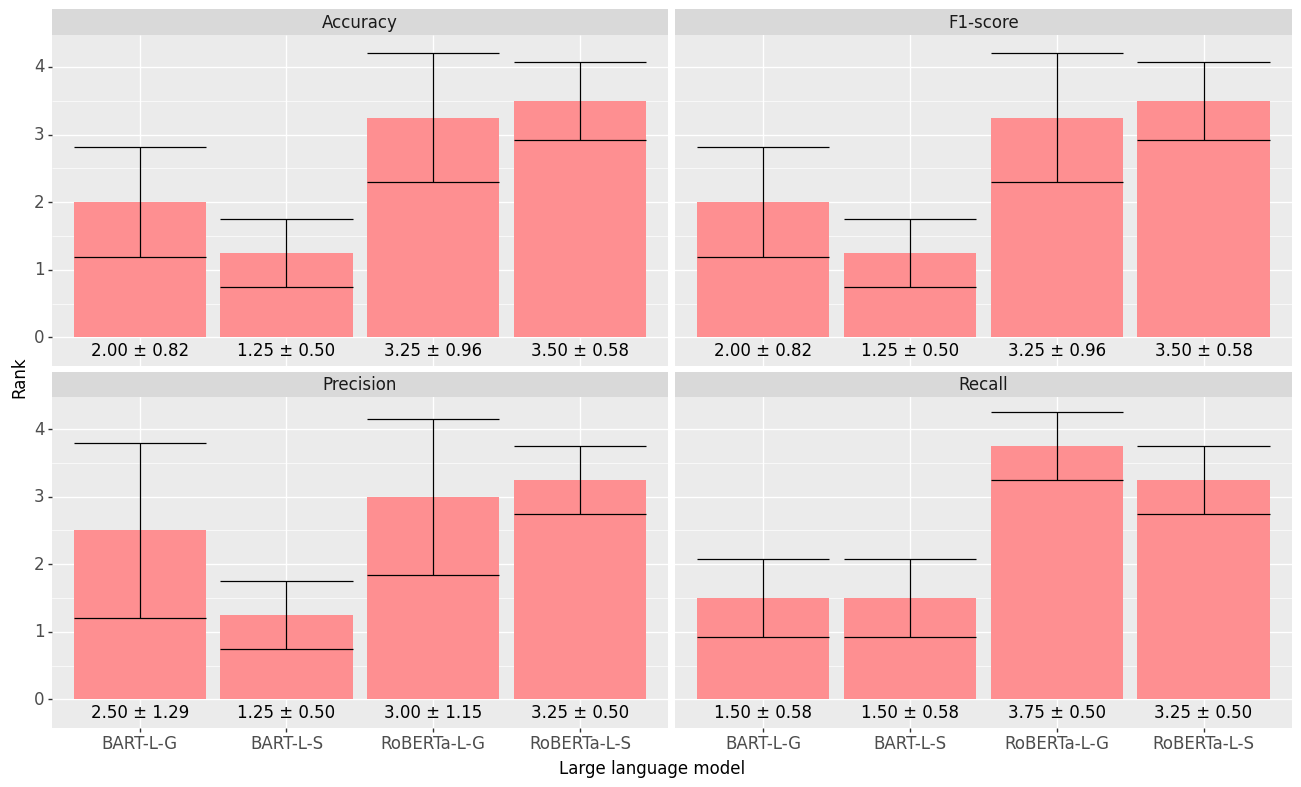

<ggplot: (376655305)>

In [21]:
p9.ggplot(best_results_df_grouped[best_results_df_grouped['split'] == 'Testing'],
  p9.aes(x = 'llm', y = 'mean')) + \
  p9.theme_gray() + \
  p9.geom_bar(stat = 'identity', position = p9.position_dodge2(), fill = '#fe8f91') + \
  p9.geom_errorbar(p9.aes(ymin = 'mean - std', ymax = 'mean + std'), position = p9.position_dodge2(), width = .9) + \
  p9.geom_text(p9.aes(y = -0.2, label = 'label'), position = p9.position_dodge2(width = .9), size = 12) + \
  p9.facet_wrap('~metric', ncol = 2) + \
  p9.xlab('Large language model') + \
  p9.ylab('Rank') + \
  p9.labs(fill = 'Graph neural network') + \
  p9.theme(
    legend_position = 'top',
    legend_box_margin = 0,
    figure_size = (16, 9),
    text = p9.element_text(size = 12)
  )

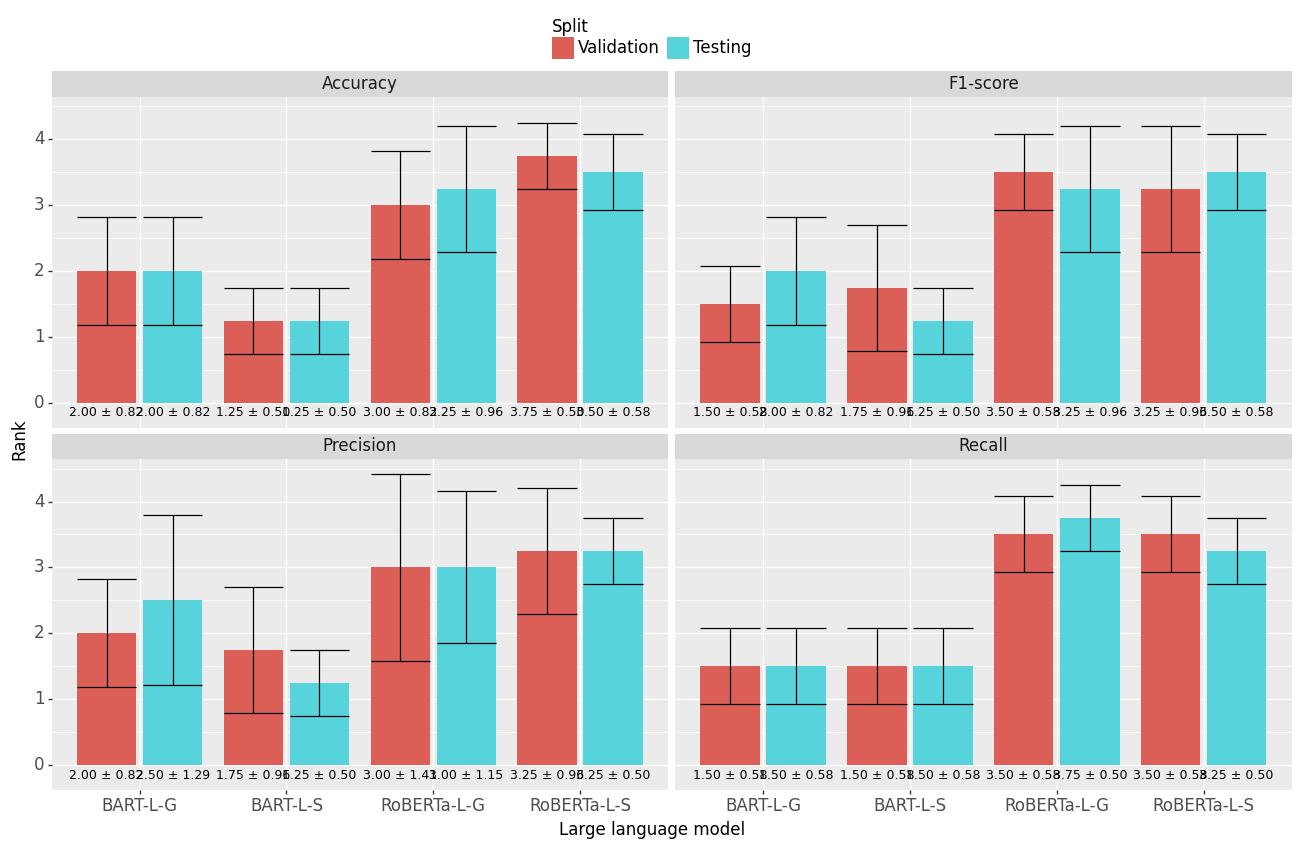

<ggplot: (376946022)>

In [22]:
p9.ggplot(best_results_df_grouped,
  p9.aes(x = 'llm', y = 'mean', fill = 'split')) + \
  p9.theme_gray() + \
  p9.geom_bar(stat = 'identity', position = p9.position_dodge2()) + \
  p9.geom_errorbar(p9.aes(ymin = 'mean - std', ymax = 'mean + std'), position = p9.position_dodge2(), width = .9) + \
  p9.geom_text(p9.aes(y = -0.15, label = 'label'), position = p9.position_dodge2(width = .9), size = 9) + \
  p9.facet_wrap('~metric', ncol = 2) + \
  p9.xlab('Large language model') + \
  p9.ylab('Rank') + \
  p9.labs(fill = 'Split') + \
  p9.theme(
    legend_position = 'top',
    legend_box_margin = 0,
    figure_size = (16, 9),
    text = p9.element_text(size = 12)
  )

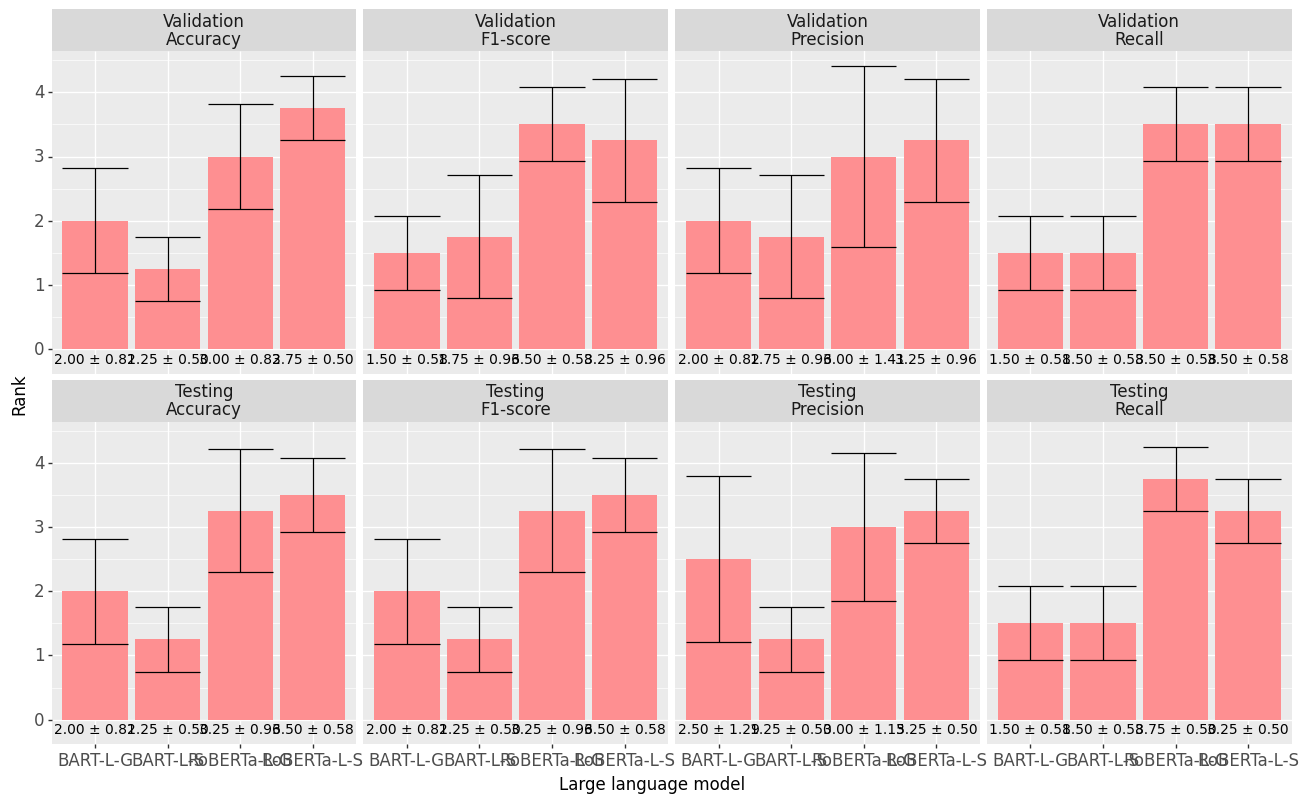

<ggplot: (377046266)>

In [23]:
p9.ggplot(best_results_df_grouped,
  p9.aes(x = 'llm', y = 'mean')) + \
  p9.theme_gray() + \
  p9.geom_bar(stat = 'identity', position = p9.position_dodge2(), fill = '#fe8f91') + \
  p9.geom_errorbar(p9.aes(ymin = 'mean - std', ymax = 'mean + std'), position = p9.position_dodge2(), width = .9) + \
  p9.geom_text(p9.aes(y = -0.15, label = 'label'), position = p9.position_dodge2(width = .9), size = 10) + \
  p9.facet_wrap('~split+metric', ncol = 4) + \
  p9.xlab('Large language model') + \
  p9.ylab('Rank') + \
  p9.theme(
    legend_position = 'top',
    figure_size = (16, 9),
    text = p9.element_text(size = 12)
  )

## Percentage change analysis

In [24]:
best_results_df.drop(columns = [x for x in best_results_df.columns if x.endswith('_rank')], inplace = True)

In [25]:
best_results_df

,dataset,target_metric,gnn,llm,method,aggregation,validation_accuracy_mean,validation_accuracy_std,validation_f1_score_mean,validation_f1_score_std,...,validation_recall_mean,validation_recall_std,test_accuracy_mean,test_accuracy_std,test_f1_score_mean,test_f1_score_std,test_precision_mean,test_precision_std,test_recall_mean,test_recall_std
0,SST-2,accuracy,GATv2,facebook-bart-large,Grouped,No_Aggregation,0.946789,0.002037,0.946756,0.002048,...,0.946678,0.002109,0.946952,0.003859,0.946937,0.003870,0.947501,0.003491,0.946978,0.003846
1,SST-2,accuracy,GATv2,facebook-bart-large,Surrogate,No_Aggregation,0.947248,0.001529,0.947211,0.001529,...,0.947120,0.001514,0.948105,0.003709,0.948092,0.003713,0.948619,0.003610,0.948128,0.003705
2,SST-2,accuracy,GATv2,FacebookAI-roberta-large,Grouped,No_Aggregation,0.928670,0.002746,0.928633,0.002763,...,0.928633,0.002817,0.930313,0.004047,0.930298,0.004060,0.930692,0.003762,0.930321,0.004038
3,SST-2,accuracy,GATv2,FacebookAI-roberta-large,Surrogate,No_Aggregation,0.932454,0.006933,0.932427,0.006944,...,0.932467,0.006953,0.934926,0.007606,0.934914,0.007613,0.935259,0.007474,0.934939,0.007607
4,R8,f1_score,GATv2,facebook-bart-large,Grouped,No_Aggregation,0.979216,0.004378,0.968748,0.006355,...,0.975923,0.004842,0.973869,0.001609,0.935613,0.005305,0.937110,0.008225,0.935968,0.004135
5,R8,f1_score,GATv2,facebook-bart-large,Surrogate,No_Aggregation,0.983409,0.001708,0.961616,0.005322,...,0.969379,0.006098,0.983234,0.000807,0.955819,0.003338,0.963013,0.004326,0.950858,0.003670
6,R8,f1_score,GATv2,FacebookAI-roberta-large,Grouped,No_Aggregation,0.980675,0.002096,0.957052,0.007765,...,0.960559,0.011416,0.976884,0.002068,0.935743,0.006011,0.951308,0.005953,0.925456,0.007325
7,R8,f1_score,GATv2,FacebookAI-roberta-large,Surrogate,No_Aggregation,0.979125,0.002485,0.962451,0.005638,...,0.965030,0.007395,0.971448,0.002362,0.927307,0.008513,0.929054,0.012697,0.928809,0.004175
8,Ohsumed,f1_score,GATv2,facebook-bart-large,Grouped,No_Aggregation,0.744345,0.013343,0.660718,0.015217,...,0.671941,0.019761,0.735518,0.006111,0.663227,0.006845,0.669634,0.008828,0.671270,0.012231
9,Ohsumed,f1_score,GATv2,facebook-bart-large,Surrogate,No_Aggregation,0.731994,0.007066,0.649650,0.005143,...,0.652520,0.007078,0.738486,0.003724,0.664003,0.007728,0.671585,0.007002,0.670449,0.007778


In [26]:
best_results_df['is_base'] = (best_results_df['gnn'] == 'GATv2') & (best_results_df['method'] == 'Grouped') & (best_results_df['aggregation'] == 'No_Aggregation') & (best_results_df['llm'] == 'FacebookAI-roberta-large')

In [27]:
for column in [x for x in best_results_df.columns if x.endswith('_mean')]:
  best_results_df[f'{column}_change'] = best_results_df[['dataset', column, 'is_base']] \
    .groupby(['dataset']) \
    .apply(
      lambda group: group.apply(
        lambda row: ((row[column] - group.loc[group['is_base'], column].values[0]) / group.loc[group['is_base'], column].values[0]) * 100
          if group['is_base'].any() else None, axis = 1
        )
    ).reset_index(drop = True)

In [28]:
best_results_df = best_results_df[~best_results_df['is_base']]

In [29]:
best_results_df

,dataset,target_metric,gnn,llm,method,aggregation,validation_accuracy_mean,validation_accuracy_std,validation_f1_score_mean,validation_f1_score_std,...,test_recall_std,is_base,validation_accuracy_mean_change,validation_f1_score_mean_change,validation_precision_mean_change,validation_recall_mean_change,test_accuracy_mean_change,test_f1_score_mean_change,test_precision_mean_change,test_recall_mean_change
0,SST-2,accuracy,GATv2,facebook-bart-large,Grouped,No_Aggregation,0.946789,0.002037,0.946756,0.002048,...,0.003846,False,1.287830,1.292771,1.263433,1.234248,1.976411,1.977037,1.939213,1.909227
1,SST-2,accuracy,GATv2,facebook-bart-large,Surrogate,No_Aggregation,0.947248,0.001529,0.947211,0.001529,...,0.003705,False,3.026401,3.052688,2.849413,3.107198,1.625757,1.637569,1.602031,1.726404
3,SST-2,accuracy,GATv2,FacebookAI-roberta-large,Surrogate,No_Aggregation,0.932454,0.006933,0.932427,0.006944,...,0.007607,False,-0.193175,-0.202399,-0.172781,-0.267564,0.988205,0.974873,1.057252,0.853555
4,R8,f1_score,GATv2,facebook-bart-large,Grouped,No_Aggregation,0.979216,0.004378,0.968748,0.006355,...,0.004135,False,3.475383,2.802484,-0.940223,4.398802,2.319100,2.279016,-0.184067,3.448596
5,R8,f1_score,GATv2,facebook-bart-large,Surrogate,No_Aggregation,0.983409,0.001708,0.961616,0.005322,...,0.003670,False,1.758378,1.080342,-0.634325,1.381414,2.731996,2.398634,0.106734,3.322070
7,R8,f1_score,GATv2,FacebookAI-roberta-large,Surrogate,No_Aggregation,0.979125,0.002485,0.962451,0.005638,...,0.004175,False,-3.185767,-3.083271,-2.490331,-3.378794,-0.973747,-0.439901,-0.042943,-1.333661
8,Ohsumed,f1_score,GATv2,facebook-bart-large,Grouped,No_Aggregation,0.744345,0.013343,0.660718,0.015217,...,0.012231,False,-0.148727,1.222030,0.843095,1.599560,-0.308642,-0.013889,-1.492499,1.135847
9,Ohsumed,f1_score,GATv2,facebook-bart-large,Surrogate,No_Aggregation,0.731994,0.007066,0.649650,0.005143,...,0.007778,False,0.278862,0.476853,0.004483,0.918228,0.650019,2.145469,1.230340,2.744788
11,Ohsumed,f1_score,GATv2,FacebookAI-roberta-large,Surrogate,No_Aggregation,0.696429,0.010845,0.622890,0.007596,...,0.013611,False,-0.158022,0.564133,0.582809,0.465487,-0.556491,-0.901517,-2.339316,0.362266
12,IMDb-top_1000,accuracy,GATv2,facebook-bart-large,Grouped,No_Aggregation,0.953333,0.004990,0.953006,0.005031,...,0.006370,False,1.951099,1.951560,1.949351,1.943220,1.788560,1.788616,1.806047,1.790387


In [30]:
best_results_df_melted = best_results_df.drop(columns = ['dataset', 'target_metric', 'gnn', 'aggregation']).melt(id_vars = ['llm', 'method'], var_name = 'information', value_name = 'value')
split_information_column = best_results_df_melted['information'].str.split('_')
best_results_df_melted['split'] = split_information_column.str[0]
best_results_df_melted['metric'] = split_information_column.str[1]
best_results_df_melted.drop(columns = ['information'], inplace = True)

In [31]:
best_results_df_melted

,llm,method,value,split,metric
0,facebook-bart-large,Grouped,0.946789,validation,accuracy
1,facebook-bart-large,Surrogate,0.947248,validation,accuracy
2,FacebookAI-roberta-large,Surrogate,0.932454,validation,accuracy
3,facebook-bart-large,Grouped,0.979216,validation,accuracy
4,facebook-bart-large,Surrogate,0.983409,validation,accuracy
...,...,...,...,...,...
295,facebook-bart-large,Surrogate,2.744788,test,recall
296,FacebookAI-roberta-large,Surrogate,0.362266,test,recall
297,facebook-bart-large,Grouped,1.790387,test,recall
298,facebook-bart-large,Surrogate,1.914084,test,recall


In [32]:
best_results_df_melted['metric'] = best_results_df_melted['metric'].replace({'f1' : 'F1-score'}).str.capitalize()
best_results_df_melted['llm'] = best_results_df_melted['llm'].replace({
  'FacebookAI-roberta-large' : 'RoBERTa-L',
  'facebook-bart-large' : 'BART-L'
})
best_results_df_melted['method'] = best_results_df_melted['method'].replace({
  'Grouped' : 'G',
  'Surrogate' : 'S'
})
best_results_df_melted['llm'] = best_results_df_melted['llm'] + '-' + best_results_df_melted['method']
best_results_df_melted.drop(columns = ['method'], inplace = True)
best_results_df_melted['split'] = best_results_df_melted['split'].replace({'test' : 'Testing'}).str.capitalize()
best_results_df_melted['split'] = pd.Categorical(best_results_df_melted['split'], categories = ['Validation', 'Testing'])

In [33]:
best_results_df_melted['value'] = best_results_df_melted['value'].astype(float)

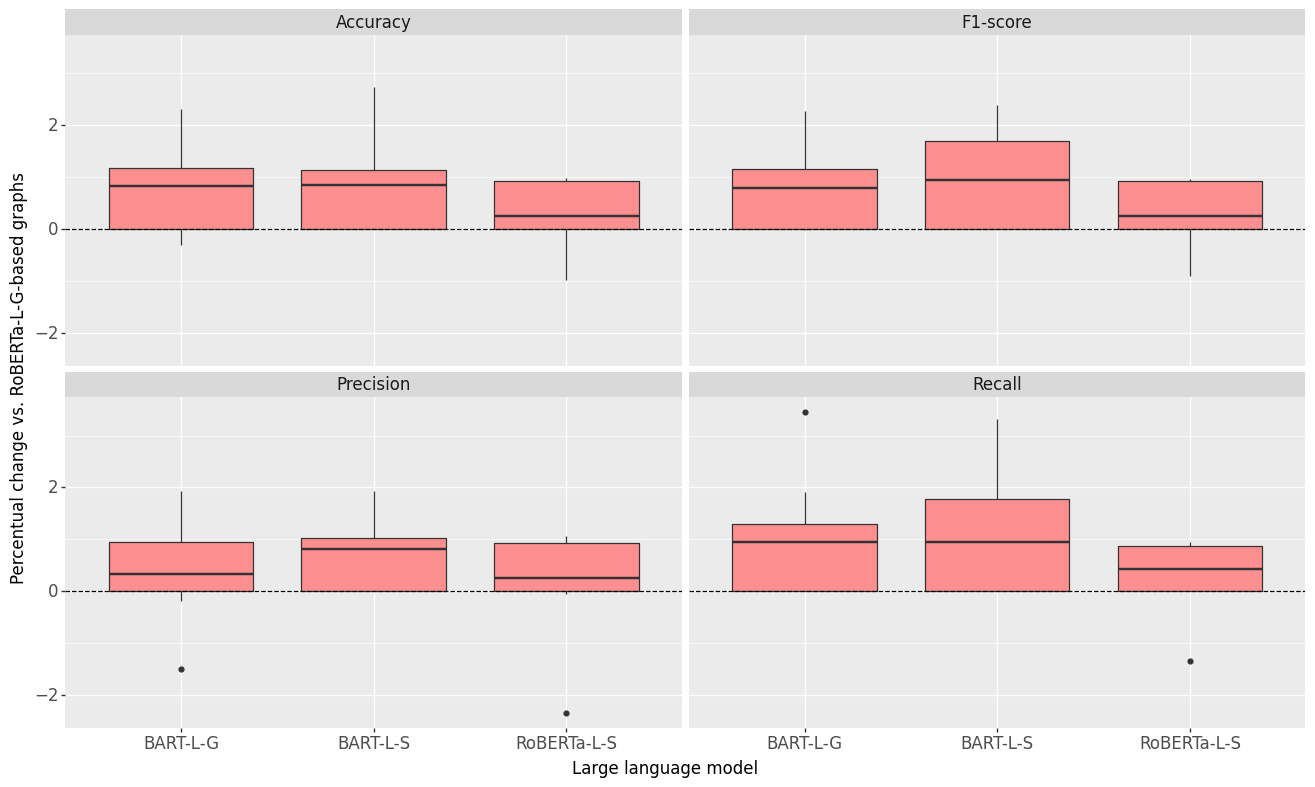

<ggplot: (375939256)>

In [34]:
p9.ggplot(best_results_df_melted[best_results_df_melted['split'] == 'Testing'],
  p9.aes(x = 'llm', y = 'value', group = 'llm')) + \
  p9.theme_gray() + \
  p9.geom_boxplot(fill = '#fe8f91') + \
  p9.geom_hline(yintercept = 0, linetype = 'dashed') + \
  p9.facet_wrap('~metric', ncol = 2) + \
  p9.xlab('Large language model') + \
  p9.ylab('Percentual change vs. RoBERTa-L-G-based graphs') + \
  p9.labs(fill = 'Graph neural network') + \
  p9.theme(
    legend_position = 'top',
    legend_box_margin = 0,
    figure_size = (16, 9),
    text = p9.element_text(size = 12)
  )

In [35]:
best_results_df_grouped = best_results_df.groupby(['llm', 'method']).agg({
  'validation_accuracy_mean_change' : ['mean', 'std'],
  'test_accuracy_mean_change' : ['mean', 'std'],
  'validation_f1_score_mean_change' : ['mean', 'std'],
  'test_f1_score_mean_change' : ['mean', 'std'],
  'validation_precision_mean_change' : ['mean', 'std'],
  'test_precision_mean_change' : ['mean', 'std'],
  'validation_recall_mean_change' : ['mean', 'std'],
  'test_recall_mean_change' : ['mean', 'std'],
}).reset_index()
best_results_df_grouped.columns = best_results_df_grouped.columns.map('_'.join).str.strip('_')

In [36]:
best_results_df_grouped = best_results_df_grouped.melt(id_vars = ['llm', 'method'], var_name = 'information', value_name = 'value')
split_information_column = best_results_df_grouped['information'].str.split('_')
best_results_df_grouped['split'] = split_information_column.str[0]
best_results_df_grouped['metric'] = split_information_column.str[1]
best_results_df_grouped['mean_std'] = split_information_column.str[-1]
best_results_df_grouped.drop(columns = ['information'], inplace = True)

In [37]:
best_results_df_grouped = best_results_df_grouped.pivot_table(index = ['llm', 'method', 'split', 'metric'], columns = 'mean_std', values = 'value').reset_index()

In [38]:
best_results_df_grouped['label'] = best_results_df_grouped['mean'].map(lambda x : '{:.2f}'.format(x)) + ' ± ' + best_results_df_grouped['std'].map(lambda x : '{:.2f}'.format(x))

In [39]:
best_results_df_grouped.head()

mean_std,llm,method,split,metric,mean,std,label
0,FacebookAI-roberta-large,Surrogate,test,accuracy,-0.011548,0.909164,-0.01 ± 0.91
1,FacebookAI-roberta-large,Surrogate,test,f1,0.032417,0.856086,0.03 ± 0.86
2,FacebookAI-roberta-large,Surrogate,test,precision,-0.208600,1.489817,-0.21 ± 1.49
3,FacebookAI-roberta-large,Surrogate,test,recall,0.094635,0.974511,0.09 ± 0.97
4,FacebookAI-roberta-large,Surrogate,validation,accuracy,-0.782364,1.625740,-0.78 ± 1.63


In [40]:
best_results_df_grouped['metric'] = best_results_df_grouped['metric'].replace({'f1' : 'F1-score'}).str.capitalize()
best_results_df_grouped['llm'] = best_results_df_grouped['llm'].replace({
  'FacebookAI-roberta-large' : 'RoBERTa-L',
  'facebook-bart-large' : 'BART-L'
})
best_results_df_grouped['method'] = best_results_df_grouped['method'].replace({
  'Grouped' : 'G',
  'Surrogate' : 'S'
})
best_results_df_grouped['llm'] = best_results_df_grouped['llm'] + '-' + best_results_df_grouped['method']
best_results_df_grouped.drop(columns = ['method'], inplace = True)

In [41]:
best_results_df_grouped['split'] = best_results_df_grouped['split'].replace({'test' : 'Testing'}).str.capitalize()
best_results_df_grouped['split'] = pd.Categorical(best_results_df_grouped['split'], categories = ['Validation', 'Testing'])

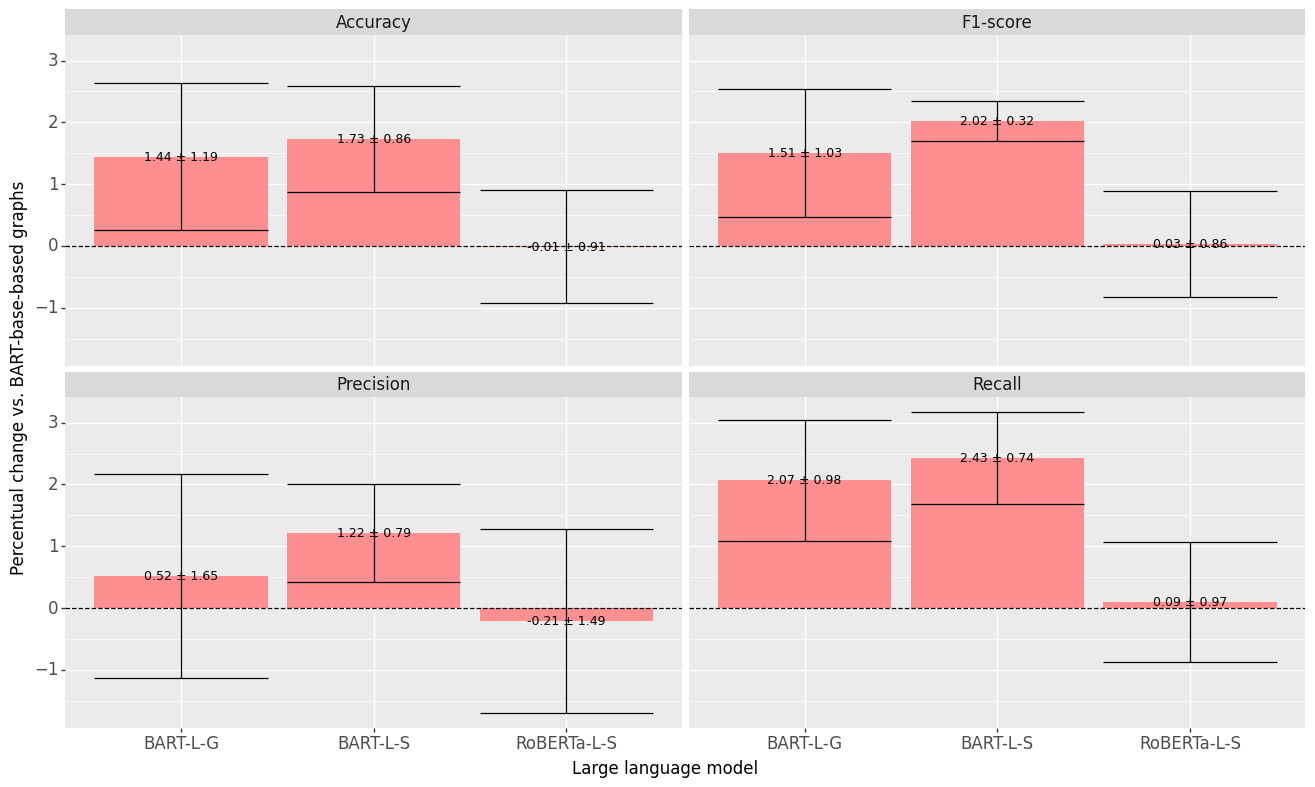

<ggplot: (375913839)>

In [42]:
p9.ggplot(best_results_df_grouped[best_results_df_grouped['split'] == 'Testing'],
  p9.aes(x = 'llm', y = 'mean')) + \
  p9.theme_gray() + \
  p9.geom_bar(stat = 'identity', position = p9.position_dodge2(), fill = '#fe8f91') + \
  p9.geom_hline(yintercept = 0, linetype = 'dashed') + \
  p9.geom_errorbar(p9.aes(ymin = 'mean - std', ymax = 'mean + std'), position = p9.position_dodge2(), width = .9) + \
  p9.geom_text(p9.aes(label = 'label'), position = p9.position_dodge2(width = .9), size = 9) + \
  p9.facet_wrap('~metric', ncol = 2) + \
  p9.xlab('Large language model') + \
  p9.ylab('Percentual change vs. BART-base-based graphs') + \
  p9.labs(fill = 'Split') + \
  p9.theme(
    legend_position = 'top',
    legend_box_margin = 0,
    figure_size = (16, 9),
    text = p9.element_text(size = 12)
  )

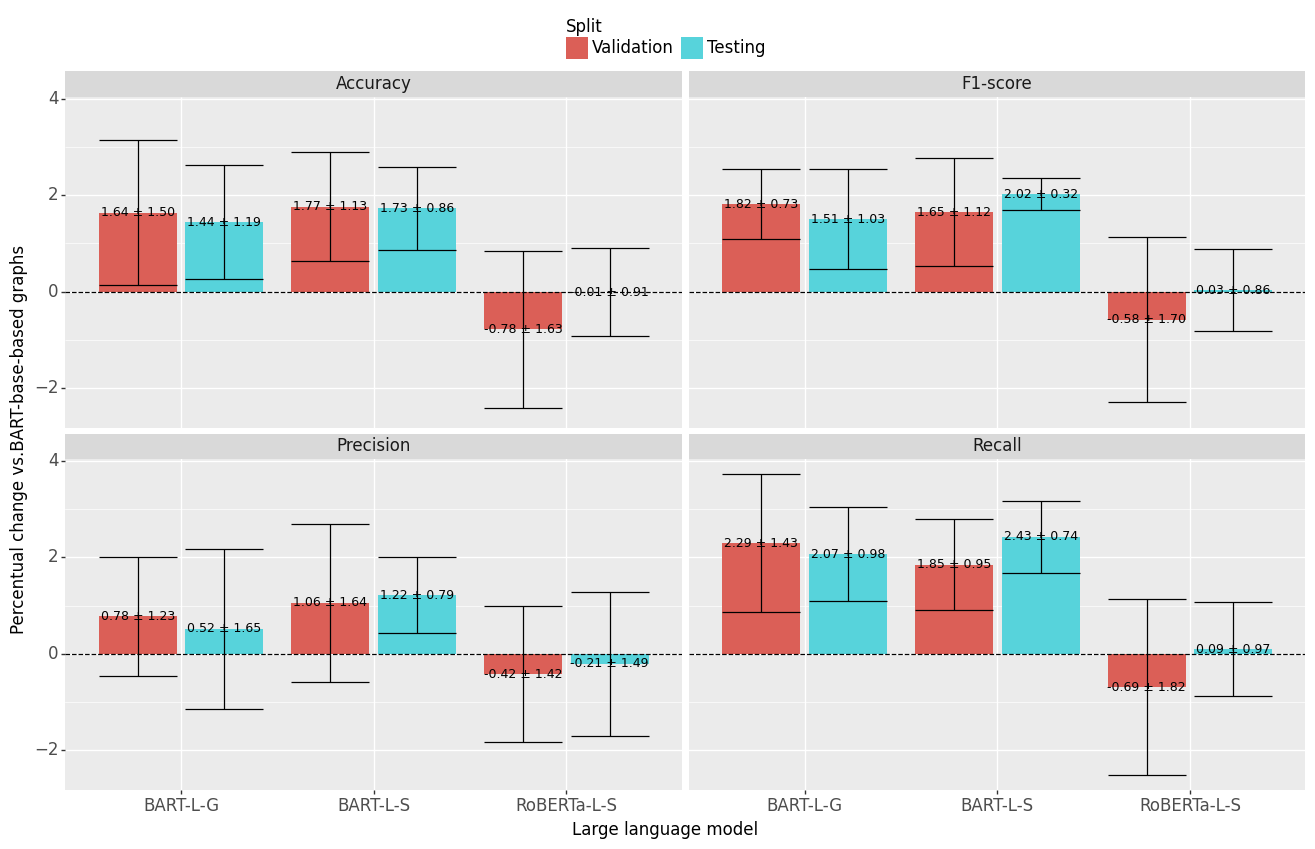

<ggplot: (376494348)>

In [43]:
p9.ggplot(best_results_df_grouped,
  p9.aes(x = 'llm', y = 'mean', fill = 'split')) + \
  p9.theme_gray() + \
  p9.geom_bar(stat = 'identity', position = p9.position_dodge2()) + \
  p9.geom_hline(yintercept = 0, linetype = 'dashed') + \
  p9.geom_errorbar(p9.aes(ymin = 'mean - std', ymax = 'mean + std'), position = p9.position_dodge2(), width = .9) + \
  p9.geom_text(p9.aes(label = 'label'), position = p9.position_dodge2(width = .9), size = 9) + \
  p9.facet_wrap('~metric', ncol = 2) + \
  p9.xlab('Large language model') + \
  p9.ylab('Percentual change vs.BART-base-based graphs') + \
  p9.labs(fill = 'Split') + \
  p9.theme(
    legend_position = 'top',
    legend_box_margin = 0,
    figure_size = (16, 9),
    text = p9.element_text(size = 12)
  )

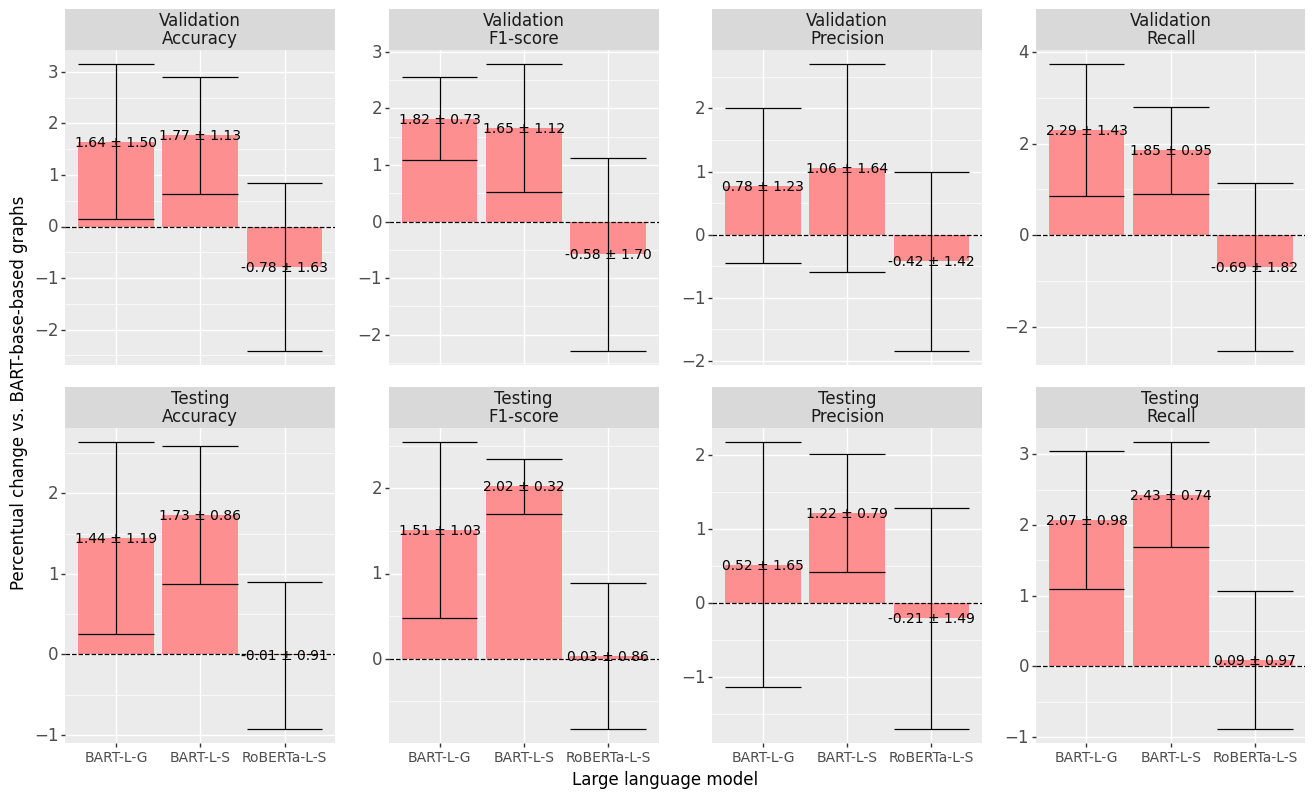

<ggplot: (376347961)>

In [44]:
p9.ggplot(best_results_df_grouped,
  p9.aes(x = 'llm', y = 'mean')) + \
  p9.theme_gray() + \
  p9.geom_bar(stat = 'identity', position = p9.position_dodge2(), fill = '#fe8f91') + \
  p9.geom_hline(yintercept = 0, linetype = 'dashed') + \
  p9.geom_errorbar(p9.aes(ymin = 'mean - std', ymax = 'mean + std'), position = p9.position_dodge2(), width = .9) + \
  p9.geom_text(p9.aes(label = 'label'), position = p9.position_dodge2(width = .9), size = 10) + \
  p9.facet_wrap('~split+metric', ncol = 4, scales = 'free_y') + \
  p9.xlab('Large language model') + \
  p9.ylab('Percentual change vs. BART-base-based graphs') + \
  p9.theme(
    legend_position = 'top',
    figure_size = (16, 9),
    text = p9.element_text(size = 12),
    axis_text_x = p9.element_text(size = 10),
    subplots_adjust = {
      'hspace': 0.2,
      'wspace': 0.2
    }
  )

# Statistical significance

In [45]:
def get_best_results_for_statistics_with_exceptions(datasets, gnns, llms, methods, aggregations, target_metrics):
  results = list()
  for dataset, target_metric in zip(datasets, target_metrics):
    for gnn in gnns:
      for llm in llms:
        for method in methods:
          for aggregation in aggregations:
            df = load_performance_metrics_with_exceptions(dataset = dataset, gnn = gnn, llm = llm, method = method, aggregation = aggregation)
            # 'trial', 'random_state', 'split', 'accuracy', 'f1_score', 'precision', 'recall'
            df = remove_trials_with_exceptions(df)
            
            df_aggregated = df.groupby(['trial', 'split']).agg({
              'accuracy' : ['mean', 'std'],
              'f1_score' : ['mean', 'std'],
              'precision' : ['mean', 'std'],
              'recall' : ['mean', 'std'],
            }).reset_index()
            df_aggregated.columns = df_aggregated.columns.map('_'.join).str.strip('_')
            
            best_trial_number = df_aggregated.sort_values(by = ['split', f'{target_metric}_mean', f'{target_metric}_std'], ascending = [True, False, True]).reset_index(drop = True).iloc[0]['trial']
            best_trial = df[df['trial'] == best_trial_number]
            best_trial['target_metric'] = best_trial[target_metric]
            best_trial.drop(columns = ['accuracy', 'f1_score', 'precision', 'recall'], inplace = True)
            best_trial['dataset'] = dataset
            best_trial['gnn'] = gnn
            best_trial['method'] = method
            best_trial['aggregation'] = aggregation
            best_trial['llm'] = llm
            results.append(best_trial)

  return pd.concat(results, axis = 0)

In [46]:
stats_df = get_best_results_for_statistics_with_exceptions(
  datasets = ['SST-2', 'R8', 'Ohsumed', 'IMDb-top_1000'],
  target_metrics = ['accuracy', 'f1_score', 'f1_score', 'accuracy'],
  gnns = ['GATv2'],
  llms = ['facebook-bart-large', 'FacebookAI-roberta-large'],
  methods = ['Grouped', 'Surrogate'],
  aggregations = ['No_Aggregation']
)

In [47]:
stats_df['llm'] = stats_df['llm'] + '-' + stats_df['method']
stats_df

,trial,random_state,split,target_metric,dataset,gnn,method,aggregation,llm
0,111,42,validation,0.948394,SST-2,GATv2,Grouped,No_Aggregation,facebook-bart-large-Grouped
1,111,42,test,0.946733,SST-2,GATv2,Grouped,No_Aggregation,facebook-bart-large-Grouped
2,111,45,validation,0.947248,SST-2,GATv2,Grouped,No_Aggregation,facebook-bart-large-Grouped
3,111,45,test,0.948380,SST-2,GATv2,Grouped,No_Aggregation,facebook-bart-large-Grouped
4,111,44,validation,0.944954,SST-2,GATv2,Grouped,No_Aggregation,facebook-bart-large-Grouped
...,...,...,...,...,...,...,...,...,...
15,375,46,test,0.952239,IMDb-top_1000,GATv2,Surrogate,No_Aggregation,FacebookAI-roberta-large-Surrogate
16,375,41,validation,0.933333,IMDb-top_1000,GATv2,Surrogate,No_Aggregation,FacebookAI-roberta-large-Surrogate
17,375,41,test,0.955224,IMDb-top_1000,GATv2,Surrogate,No_Aggregation,FacebookAI-roberta-large-Surrogate
18,375,40,validation,0.945455,IMDb-top_1000,GATv2,Surrogate,No_Aggregation,FacebookAI-roberta-large-Surrogate


In [48]:
# Based on https://www.geeksforgeeks.org/how-to-conduct-a-paired-samples-t-test-in-python/
for i, split in enumerate(['validation', 'test']):
  print(split)
  split_df = stats_df[(stats_df['split'] == split)].drop(columns = ['trial', 'split', 'gnn', 'method', 'aggregation']) \
    .pivot(index = ['dataset', 'random_state'], columns = 'llm', values = 'target_metric') \
    .reset_index() \
    .sort_values(by = ['dataset', 'random_state'])
  
  for (x, y) in itertools.combinations(['facebook-bart-large-Grouped', 'facebook-bart-large-Surrogate', 'FacebookAI-roberta-large-Grouped', 'FacebookAI-roberta-large-Surrogate'], 2):
    # H0: Mean Grouped and Surrogate scores are equal
    # H1: Mean Grouped and Surrogate scores are not equal
    statistic, p_value = stats.ttest_rel(split_df[x], split_df[y])
    # 95% confidence -- p-value < 0.05 => reject the null hypothesis (H0), i.e., the true mean test score is different between the approaches
    print(f'{x} - {y}:', 'Statistic:', statistic, 'P-value:', p_value, 'Reject H0?', p_value < 0.05)
  print('')

validation
facebook-bart-large-Grouped - facebook-bart-large-Surrogate: Statistic: 0.1512415500982 P-value: 0.8805647922048658 Reject H0? False
facebook-bart-large-Grouped - FacebookAI-roberta-large-Grouped: Statistic: 7.396162951172661 P-value: 6.16279294928249e-09 Reject H0? True
facebook-bart-large-Grouped - FacebookAI-roberta-large-Surrogate: Statistic: 7.800929447064354 P-value: 1.748632257139956e-09 Reject H0? True
facebook-bart-large-Surrogate - FacebookAI-roberta-large-Grouped: Statistic: 6.882151759671173 P-value: 3.1116788418010473e-08 Reject H0? True
facebook-bart-large-Surrogate - FacebookAI-roberta-large-Surrogate: Statistic: 7.909206041544078 P-value: 1.2517014277884585e-09 Reject H0? True
FacebookAI-roberta-large-Grouped - FacebookAI-roberta-large-Surrogate: Statistic: 1.3739417484298415 P-value: 0.1773054759658808 Reject H0? False

test
facebook-bart-large-Grouped - facebook-bart-large-Surrogate: Statistic: -2.5291920285859013 P-value: 0.015587298127648183 Reject H0? Tr